In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot
import tensorflow as tf
import pickle
import os

In [10]:
import dataset_utils
from glob import glob

In [11]:
DATA_DIR = "pointnet_data"
NUM_POINTS = 100
NUM_CLASSES = 2
BATCH_SIZE = 32
train_points, test_points, train_labels, test_labels, CLASS_MAP = dataset_utils.parse_dataset(NUM_POINTS, DATA_DIR)

processing class: standing
processing class: sitting


In [12]:
print(train_points)

[[[ 1.103e+00  3.711e+00  1.076e+00 -1.252e-01  3.030e+02]
  [ 1.558e+00  2.998e+00  1.118e+00 -3.757e-01  1.290e+02]
  [ 1.103e+00  3.688e+00  1.099e+00 -1.252e-01  3.160e+02]
  ...
  [ 1.152e+00  3.707e+00  1.095e+00 -1.252e-01  3.060e+02]
  [ 1.360e+00  2.941e+00  1.029e+00 -3.757e-01  1.590e+02]
  [ 1.530e+00  3.023e+00  1.300e+00 -5.010e-01  1.680e+02]]

 [[ 9.590e-01  3.182e+00  1.292e+00 -5.010e-01  1.890e+02]
  [ 1.505e+00  2.902e+00  1.062e+00 -3.757e-01  1.450e+02]
  [ 6.401e-01  3.594e+00  1.041e+00  2.505e-01  3.420e+02]
  ...
  [ 1.152e+00  3.707e+00  1.095e+00 -1.252e-01  3.060e+02]
  [ 1.007e+00  3.523e+00  1.196e+00  0.000e+00  2.160e+02]
  [ 7.441e-01  3.316e+00  1.235e+00  3.757e-01  3.110e+02]]

 [[ 1.101e+00  2.803e+00  1.065e+00 -7.515e-01  2.200e+02]
  [ 2.275e-01  2.227e+00  1.596e+00 -5.010e-01  3.190e+02]
  [ 1.045e+00  3.553e+00  1.310e+00  0.000e+00  2.140e+02]
  ...
  [ 1.103e+00  3.688e+00  1.099e+00 -1.252e-01  3.160e+02]
  [ 7.998e-01  3.363e+00  1.244e+0

In [13]:
print(test_points)

[[[ 1.353e-01  1.683e+00  1.291e+00 -2.505e-01  2.070e+02]
  [ 3.779e-01  1.599e+00  9.541e-01  2.505e-01  1.740e+02]
  [ 3.564e-01  1.688e+00  1.145e+00 -2.505e-01  2.050e+02]
  ...
  [ 1.953e-03  1.620e+00  1.079e+00 -6.260e-01  2.140e+02]
  [ 8.643e-02  1.637e+00  1.082e+00 -2.505e-01  2.030e+02]
  [ 2.842e-01  1.527e+00  8.652e-01  3.757e-01  2.180e+02]]

 [[ 1.847e+00  3.963e+00  6.162e-01  1.252e-01  1.150e+02]
  [ 8.643e-02  1.637e+00  1.082e+00 -2.505e-01  2.030e+02]
  [ 1.382e-01  1.584e+00  1.859e+00 -5.010e-01  3.220e+02]
  ...
  [ 1.912e+00  4.043e+00  6.211e-01  3.757e-01  2.440e+02]
  [-1.250e-01  1.711e+00  1.535e+00 -6.260e-01  2.780e+02]
  [ 1.598e+00  3.977e+00  6.309e-01  1.252e-01  1.270e+02]]

 [[-2.686e-01  3.207e+00  7.139e-01 -5.010e-01  2.550e+02]
  [ 1.353e-01  1.367e+00  8.701e-01 -3.757e-01  1.230e+02]
  [ 1.544e+00  3.945e+00  7.871e-01 -1.252e-01  1.300e+02]
  ...
  [ 2.637e-01  1.557e+00  9.590e-01  2.505e-01  2.420e+02]
  [ 5.908e-02  1.400e+00  1.410e+0

In [14]:
train_points = train_points[:, :, :3]
test_points = test_points[:, :, :3]
print(CLASS_MAP)

{0: 'standing', 1: 'sitting'}


In [15]:
print(train_points)

[[[ 1.103    3.71     1.076  ]
  [ 1.558    2.998    1.118  ]
  [ 1.103    3.688    1.099  ]
  ...
  [ 1.152    3.707    1.095  ]
  [ 1.36     2.941    1.029  ]
  [ 1.53     3.023    1.3    ]]

 [[ 0.959    3.182    1.292  ]
  [ 1.505    2.902    1.062  ]
  [ 0.64     3.594    1.041  ]
  ...
  [ 1.152    3.707    1.095  ]
  [ 1.007    3.523    1.196  ]
  [ 0.744    3.316    1.235  ]]

 [[ 1.101    2.803    1.065  ]
  [ 0.2275   2.227    1.596  ]
  [ 1.045    3.553    1.31   ]
  ...
  [ 1.103    3.688    1.099  ]
  [ 0.8      3.363    1.244  ]
  [ 0.587    3.527    1.123  ]]

 ...

 [[-0.5215   1.526    0.625  ]
  [-0.2197   2.824    0.2676 ]
  [-0.669    1.335    0.6123 ]
  ...
  [-0.8      1.429    0.3477 ]
  [-0.3125   2.803    0.3389 ]
  [-0.5996   1.356    0.581  ]]

 [[-1.       1.418    0.632  ]
  [ 0.01465  3.258    1.054  ]
  [ 0.2148   3.547    1.24   ]
  ...
  [-0.587    1.517    0.546  ]
  [-0.631    1.815    0.2236 ]
  [-0.7275   1.675    0.629  ]]

 [[ 0.936    3.875    0.

In [26]:
from tensorflow import data as tf_data
import keras
import PointNET

keras.utils.set_random_seed(seed=42)

In [27]:
train_size = 0.8
dataset = tf_data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))
train_dataset_size = int(len(dataset) * train_size)

dataset = dataset.shuffle(len(train_points)).map(PointNET.augment)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

train_dataset = dataset.take(train_dataset_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_dataset_size).batch(BATCH_SIZE)

In [28]:
import keras
import tensorflow as tf
from keras import ops
from keras import layers
from PointNET import tnet, conv_bn, dense_bn

In [29]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 100, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 100, 32)   │        128 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 32)   │        128 │ conv1d_22[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_34       │ (None, 100, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 100, 64)   │      2,112 │ activation_34[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 64)   │        256 │ conv1d_23[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_35       │ (None, 100, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 100, 512)  │     33,280 │ activation_35[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 512)  │      2,048 │ conv1d_24[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 100, 512)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ activation_36[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 256)       │    131,328 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_18[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_37       │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 128)       │     32,896 │ activation_37[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_19[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_38       │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 9)         │      1,161 │ activation_38[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 3, 3)      │          0 │ dense_20[0][0]  

 Total params: 747,947 (2.85 MB)

 Trainable params: 741,867 (2.83 MB)

 Non-trainable params: 6,080 (23.75 KB)

In [30]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=validation_dataset)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 51.4632 - sparse_categorical_accuracy: 0.8898 - val_loss: 31.7163 - val_sparse_categorical_accuracy: 0.9931
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 34.5419 - sparse_categorical_accuracy: 0.9658 - val_loss: 32.7379 - val_sparse_categorical_accuracy: 0.8264
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 34.3463 - sparse_categorical_accuracy: 0.9955 - val_loss: 31.3359 - val_sparse_categorical_accuracy: 0.9792
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 34.1967 - sparse_categorical_accuracy: 0.9860 - val_loss: 31.4513 - val_sparse_categorical_accuracy: 0.9792
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 34.2572 - sparse_categorical_accuracy: 0.9989 - val_loss: 31.4617 - val_sparse_categorical_accuracy: 1.0000
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 34.1643 - sparse_categorical_accuracy: 0.9909 - val_loss: 31.3260 - val_sparse_categorical_accuracy: 1.000

In [31]:
from matplotlib import pyplot as plt

2024-08-08 15:55:30.203130: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
[[[-0.2305   3.303    0.7305 ]
  [-0.4648   2.96     1.039  ]
  [ 0.168    2.59     0.8223 ]
  ...
  [ 0.0952   3.348    0.966  ]
  [ 0.6606   3.318    0.574  ]
  [ 0.865    3.236    0.839  ]]

 [[-0.3008   1.764    0.29   ]
  [-0.5215   1.538    0.6377 ]
  [-0.542    1.853    0.207  ]
  ...
  [-0.3909   1.64     0.841  ]
  [-0.672    1.373    0.703  ]
  [-0.5      1.127    0.6953 ]]

 [[ 0.4443   2.523   -0.0586 ]
  [ 0.1982   1.69     0.4248 ]
  [ 0.571    3.291    1.22   ]
  ...
  [-0.4453   1.987    0.2275 ]
  [ 0.2637   1.687    0.5244 ]
  [ 0.2637   1.687    0.5244 ]]

 ...

 [[-0.309    1.633    1.247  ]
  [ 1.066    3.5      0.5527 ]
  [ 1.002    3.547    1.234  ]
  ...
  [-0.3994   3.285    0.8066 ]
  [ 1.525    3.715    1.206  ]
  [-0.544    3.217    0.785  ]]

 [[-0.6636   1.34     0.506  ]
  [-0.5273   1.5205   0.6816 ]
  [ 0.3164   1.815    0.4854 ]
  ...
  [ 0.4941   2.148    0.2559 ]
  [ 0.44     3.258    1.148  ]
  [ 0.6504   1.973

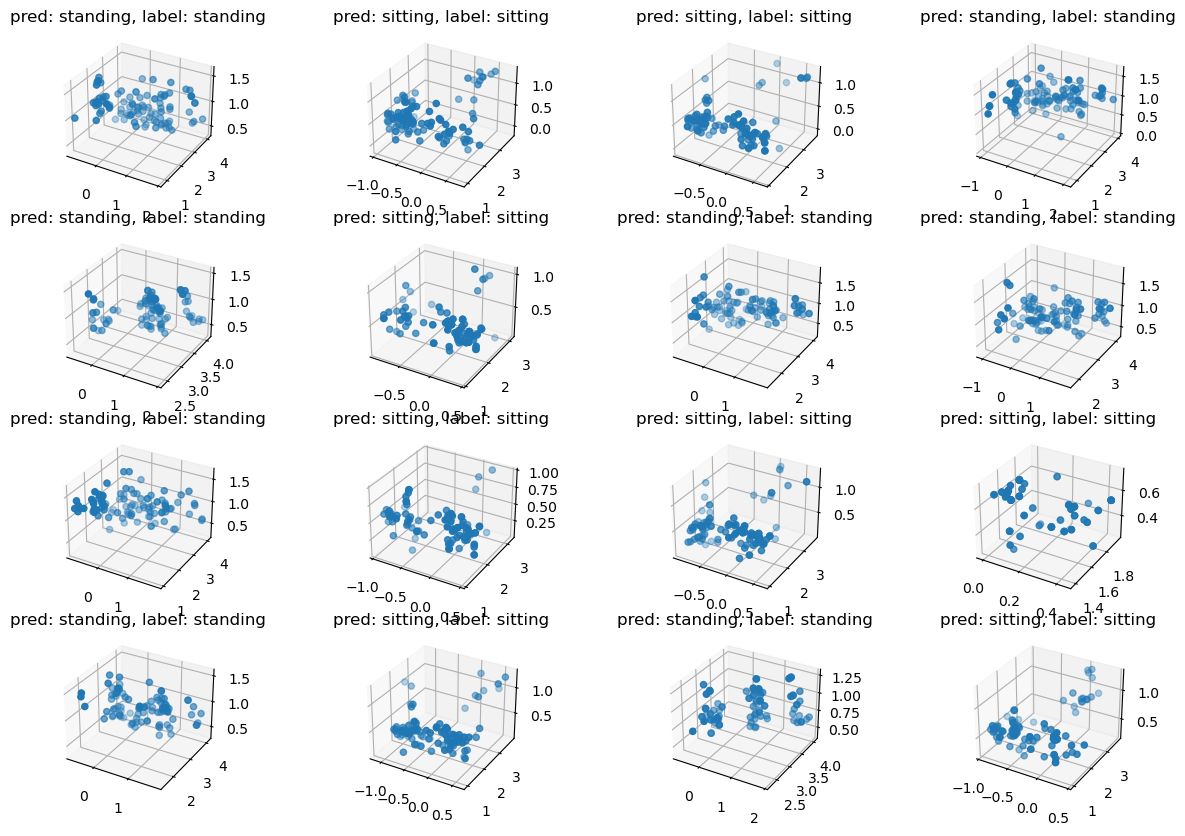

In [32]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:20, ...]
labels = labels[:20, ...]

# run test data through model
preds = model.predict(points)
preds = ops.argmax(preds, -1)

points = points.numpy()
print(points)

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_on()
plt.show()

In [33]:
predictions = []

for batch in np.array_split(test_points, len(test_points)//NUM_POINTS): 
    preds = model.predict(batch)
    preds = np.argmax(preds, axis=-1)
    predictions.extend(preds)

predictions = np.array(predictions)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [34]:
accuracy = np.sum(predictions == test_labels) / len(test_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 100.00%


In [45]:
model.save('pointnet.h5', save_format='h5')
# model.get_config()

NotImplementedError: <PointNET.OrthogonalRegularizer object at 0x347530b20> does not implement get_config()